In [1]:
!pip install langgraph langchain_openai langchain_core httpx

In [ ]:
import os
import glob
from typing import Annotated, List, Literal
from langgraph.graph import StateGraph, END
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from typing_extensions import TypedDict ,Optional, List, Dict, Any
from langgraph.graph.message import add_messages
from langchain_core.pydantic_v1 import BaseModel, Field


os.environ["OPENAI_API_VERSION"] = "2024-08-01-preview"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://xxxxxxxxxx.openai.azure.com"
os.environ["AZURE_OPENAI_API_KEY"] = "xxxxxxxxx"


model = AzureChatOpenAI(
    azure_deployment="gpt-4o",  # or your deployment
    temperature=0,
)



In [3]:
#ワークフローを流れるデータの型を指定する。
class State(TypedDict, total=False):
    message_type: Optional[str]
    messages: Optional[str]

#分類器LLMの出力を固定するクラスを指定する
class MessageType(BaseModel):
    message_type: str = Field(description="The type of the message", example="search")

#AIエージェントが選択するツールの選択出力を固定するクラスを指定する
class ToolType(BaseModel):
    message_type: str = Field(description="Must use the Tool", example="tool01")

In [ ]:
#AIエージェントがユーザの質問（今日か明日か明後日か）を分類し、適切なワークフロー（tool01からtool03）を呼び出すための関数の定義

#出力を固定するため
tools = model.with_structured_output(ToolType)

def select_tool(State):
    # プロンプトの作成
    classification_prompt = """
    ## You are a message classifier.
    ## 今日についての質問の場合は"tool01"と返答してください。
    ## 明日についての質問の場合は"tool02"と返答してください。
    ## 明後日についての質問の場合は"tool03"と返答してください。

    ## user message: {user_message}
    """

    if State["messages"]:
        return {
            "message_type": tools.invoke(classification_prompt.format(user_message=State["messages"])).message_type,
            "messages": State["messages"]
            }
    else:
        return {"message": "No user input provided"}

In [ ]:
# tool01からtool03までで利用する、ユーザの質問（天気か日付か）を分類するLLMノードを定義

#出力を固定するため
classifier = model.with_structured_output(MessageType)

#ノードで実行される関数を定義
def classify(State):
    # プロンプトの作成
    classification_prompt = """
    ## You are a message classifier.
    ## ユーザが天気に関しての質問をしていたら"weather"と返答してください。
    ##　それ以外の質問をしていたら、"day"と返答してください。

    ## user message: {user_message}
    """

    if State["messages"]:
        return {
            "message_type": classifier.invoke(classification_prompt.format(user_message=State["messages"])).message_type,
            "messages": State["messages"]
            }
    else:
        return {"message": "No user input provided"}

In [4]:
#tool01ワークフローの質問回答LLMノードを定義
def chat_w1(State):
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザからの質問を繰り返してください。その後、質問に回答してください。ただし今日は雨です")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}

def chat_d1(State):
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザの質問内容を繰り返し発言した後、それに対して回答してください。ただし今日は10/23です")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}

#tool02ワークフローの質問回答LLMノードを定義
def chat_w2(State):
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザからの質問を繰り返してください。その後、質問に回答してください。ただし明日は曇りです")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}

def chat_d2(State):
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザの質問内容を繰り返し発言した後、それに対して回答してください。ただし明日は10/24です")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}

#tool03ワークフローの質問回答LLMノードを定義
def chat_w3(State):
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザからの質問を繰り返してください。その後、質問に回答してください。ただし明後日は晴れです")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}

def chat_d3(State):
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザの質問内容を繰り返し発言した後、それに対して回答してください。ただし明後日は10/25です")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}

# 最終出力ノードを定義
def response(State):
    return State

In [7]:
#各ワークフローは整理のため、子ノードとして定義する

#子ノードを流れるデータの型を定義
class ChildState(TypedDict, total=False):
    message_type: Optional[str]
    messages: Optional[str]

#tool01ワークフローのノードとエッジを定義する
# ノードの追加
child_builder1 = StateGraph(ChildState)
child_builder1.add_node("classify1", classify)
child_builder1.add_node("chat_w1", chat_w1)
child_builder1.add_node("chat_d1", chat_d1)
child_builder1.add_node("response1", response)

# エッジの追加
child_builder1.add_edge("chat_d1", "response1")
child_builder1.add_edge("chat_w1", "response1")
# 条件分岐
child_builder1.add_conditional_edges("classify1", lambda state: state["message_type"], {"weather": "chat_w1", "day": "chat_d1"})

# 開始位置、終了位置の指定
child_builder1.set_entry_point("classify1")
child_builder1.set_finish_point("response1")

#tool02ワークフローのノードとエッジを定義する
# ノードの追加
child_builder2 = StateGraph(ChildState)
child_builder2.add_node("classify2", classify)
child_builder2.add_node("chat_w2", chat_w2)
child_builder2.add_node("chat_d2", chat_d2)
child_builder2.add_node("response2", response)

# エッジの追加
child_builder2.add_edge("chat_d2", "response2")
child_builder2.add_edge("chat_w2", "response2")
# 条件分岐
child_builder2.add_conditional_edges("classify2", lambda state: state["message_type"], {"weather": "chat_w2", "day": "chat_d2"})

# 開始位置、終了位置の指定
child_builder2.set_entry_point("classify2")
child_builder2.set_finish_point("response2")

#tool03ワークフローのノードとエッジを定義する
# ノードの追加
child_builder3 = StateGraph(ChildState)
child_builder3.add_node("classify3", classify)
child_builder3.add_node("chat_w3", chat_w3)
child_builder3.add_node("chat_d3", chat_d3)
child_builder3.add_node("response3", response)

# エッジの追加
child_builder3.add_edge("chat_d3", "response3")
child_builder3.add_edge("chat_w3", "response3")
# 条件分岐
child_builder3.add_conditional_edges("classify3", lambda state: state["message_type"], {"weather": "chat_w3", "day": "chat_d3"})

# 開始位置、終了位置の指定
child_builder3.set_entry_point("classify3")
child_builder3.set_finish_point("response3")



In [8]:
#子ノードとして定義したワークフローを利用して、AiエージェントのStateGraphを定義する

# ノードの追加
graph_builder = StateGraph(State)
graph_builder.add_node("select_tool", select_tool)
graph_builder.add_node("start_tool01", child_builder1.compile())
graph_builder.add_node("start_tool02", child_builder2.compile())
graph_builder.add_node("start_tool03", child_builder3.compile())
graph_builder.add_node("response", response)

# エッジの追加
graph_builder.add_edge("start_tool01", "response")
graph_builder.add_edge("start_tool02", "response")
graph_builder.add_edge("start_tool03", "response")
# 条件分岐
graph_builder.add_conditional_edges("select_tool", lambda state: state["message_type"], {"tool01": "start_tool01", "tool02": "start_tool02", "tool03": "start_tool03"})

# 開始位置、終了位置の指定
graph_builder.set_entry_point("select_tool")
graph_builder.set_finish_point("response")

# グラフ構築
graph = graph_builder.compile()

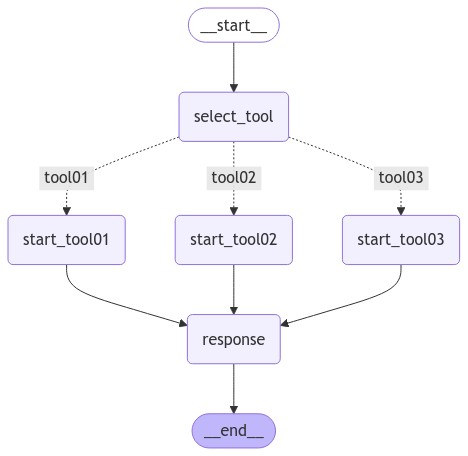

In [9]:
#最終的なグラフを可視化する
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# インタラクションループ
user_input = input("Your message: ")
while user_input.lower() != "exit":

        # 入力を State 構造に合わせる
        state = {
            "messages": [
                    ("system",""),

                    ("human", user_input),
            ]
        }

        # 応答を取得して表示
        last_content = None

        for event in graph.stream(state):
            # 最後の 'response' から 'messages' の content を取得
            if "response" in event and "messages" in event["response"]:
                messages = event["response"]["messages"]
                # AIMessage オブジェクトなら content 属性を取得
                if hasattr(messages, "content"):
                    last_content = messages.content

        # 最後のメッセージを表示
        if last_content:
            print("Assistant:", last_content)
        else:
            print("No content found.")

        user_input = input("Your message: ")
print("Goodbye!")

Your message: 明後日は傘が必要ですか？
Assistant: 明後日は傘が必要ですか？

明後日は晴れですので、傘は必要ありません。
Your message: 明日は緑の日ですか？
Assistant: 明日は緑の日ですか？

いいえ、明日は緑の日ではありません。緑の日は日本では5月4日に祝われます。明日は10月24日です。
Your message: 明日は傘を持って行かなくてもいいですか？
Assistant: 明日は傘を持って行かなくてもいいですか？

明日は曇りですので、傘を持って行かなくても大丈夫かもしれませんが、念のため天気予報を確認しておくと安心です。
Your message: exit
Goodbye!
